In [283]:
import networkx as nx
from networkx.algorithms import isomorphism
import numpy as np
import matplotlib as plt
import os
import scipy.special
import json
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from logging import Logger
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from tqdm import trange
from scipy import stats
import copy

In [2]:
# Generate a dataset of random, simple, complete graphs
full_dataset_name = "full_graph_dataset"
num_nodes = 10
graphs_per_edge_number = 100

In [ ]:
edge_num_low = num_nodes - 1  # Lowest number of edges (|V| - 1)
edge_num_hi = int(scipy.special.binom(num_nodes, 2))  # Highest number of edges (complete graph)
os.makedirs(full_dataset_name, exist_ok=True)
counter = 0
for i in range(edge_num_low, edge_num_hi):
    for j in range(graphs_per_edge_number):
        graph = nx.dense_gnm_random_graph(num_nodes, i)  # Generate a random simple graph
        if nx.is_connected(graph):  # Record the graph if it is connected
            for k in range(len(list(graph.degree))):  # Set node attribute to be node degree
                graph.nodes[k]['deg'] = list(graph.degree)[k][1]
            nx.write_gml(graph, full_dataset_name + "/graph." + "{:04d}".format(counter))  # Write graph to file
            counter += 1

In [3]:
# Generate a training dataset of graphs with deleted edges and corresponding subisomorphism targets
training_dataset_name = "training_graph_dataset"

In [ ]:
os.makedirs(training_dataset_name, exist_ok=True)
for root, subfolders, files in os.walk(full_dataset_name):
    for f in files:
        path = os.path.join(root, f)  # File path of a graph
        graph_number = f[-4:]
        original_graph = nx.read_gml(path, destringizer=int)  # Read a graph from file
        new_graph = original_graph.copy()  # Make a copy of the graph 
        d = 0.2*np.random.uniform(0, 1) + 0.7*np.random.beta(3, 3)  # Random fraction of remaining edges
        num_deletions = int((1 - d)*(len(list(original_graph.edges))))  # Integer number of edges to delete 
        for _ in range(num_deletions):  # Delete edges from the graph
            num_edge_to_delete = np.random.randint(0, len(list(new_graph.edges)))
            new_graph.remove_edge(list(new_graph.edges)[num_edge_to_delete][0], list(new_graph.edges)[num_edge_to_delete][1])
        
        target = np.zeros([num_nodes, num_nodes])  # Target matrix showing subisomorphic edge additions as 1s
        test_graph = new_graph.copy()  # Make a copy of the new, deleted-edges graph
        for i in range(num_nodes):
            for j in range(num_nodes):  
                if i < j and (i, j) not in new_graph.edges and test_graph.degree[i] < test_graph.nodes[i]['deg'] and test_graph.degree[j] < test_graph.nodes[j]['deg']:  # Check that i < j so we don't doulbe count edges, that (i, j) is not already in the graph, and that adding edge (i, j) doesn't violate any degree constraints
                    test_graph.add_edge(i, j)  # Try adding a new edge between nodes i and j and check if it is subisomorphic
                    if isomorphism.GraphMatcher(nx.line_graph(original_graph), nx.line_graph(test_graph)).subgraph_is_isomorphic():
                        target[i, j] = 1.0
                        target[j, i] = 1.0
                    test_graph = new_graph.copy()
        
        nx.write_gml(new_graph, training_dataset_name + "/partial_graph." + graph_number)
        np.savetxt(training_dataset_name + "/target." + graph_number, target)

In [75]:
# Generate an evaluation dataset of graphs that have no edges and only vertices with final degree information
evaluation_dataset_name = "evaluation_graph_dataset"

In [83]:
os.makedirs(evaluation_dataset_name, exist_ok = True)
for root, subfolders, files in os.walk(full_dataset_name):
    for f in files:
        path = os.path.join(root, f)  # File path of a graph
        graph_number = f[-4:]
        original_graph = nx.read_gml(path, destringizer=int)  # Read a graph from file
        new_graph = original_graph.copy()  # Make a copy of the graph
        for i in range(num_nodes):
            for j in range(num_nodes):
                if (i, j) in new_graph.edges:
                    new_graph.remove_edge(i, j)
                    
        nx.write_gml(new_graph, evaluation_dataset_name + "/empty_graph." + graph_number)
        
        target = np.zeros([num_nodes, num_nodes])  # Empty target matrix
        np.savetxt(evaluation_dataset_name + "/target." + graph_number, target)

In [4]:
# Test an example
original_graph = nx.read_gml(full_dataset_name + "/graph.00000", destringizer=int)
partial_graph = nx.read_gml(training_dataset_name + "/partial_graph.0000", destringizer=int)
target = np.loadtxt(training_dataset_name + "/target.0000")

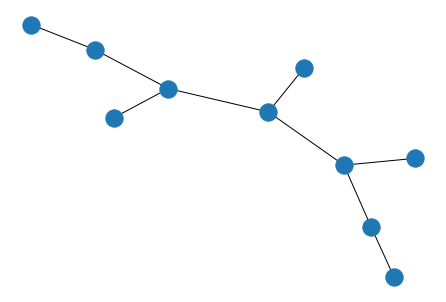

In [5]:
nx.draw(original_graph)

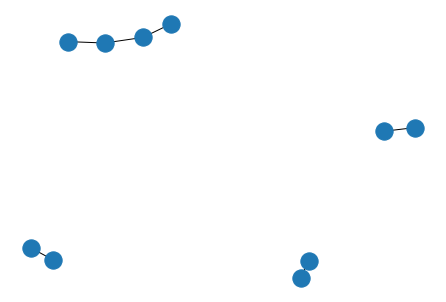

In [6]:
nx.draw(partial_graph)

In [7]:
print(target)
print(partial_graph.edges)

[[0. 1. 1. 0. 1. 0. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[(0, 6), (1, 4), (1, 8), (2, 5), (3, 4), (7, 9)]


In [8]:
test_graph = partial_graph.copy()
test_graph.add_edge(0, 8)
isomorphism.GraphMatcher(nx.line_graph(original_graph), nx.line_graph(test_graph)).subgraph_is_isomorphic()

False

In [9]:
print(partial_graph.degree[8])
print(partial_graph.nodes[8])

1
{'deg': 1}


In [10]:
# Create metadata file 
metadata_folder_name = "metadata"
metadata_file_name = "metadata.json"
data = []
for root, subfolders, files in os.walk(training_dataset_name):
    for f in files:
        if f[:7] == "partial":
            graph_path = os.path.join(root, f)
            target_path = os.path.join(root, "target."+f[-4:])
            uid = f[f.find('.') + 1:f.find('.') + 5]
            data.append({'graph_path': graph_path, 'target_path': target_path, 'uid': uid})
os.makedirs(metadata_folder_name, exist_ok=True)
json.dump(data, open(metadata_folder_name+'/'+metadata_file_name, 'w'), indent=4, sort_keys=True)

In [11]:
# loop_PyTorch 
def contains_self_loops(edge_index):
    """Returns a boolean for existence of self-loops in the graph"""
    row, col = edge_index
    mask = row == col
    return mask.sum().item() > 0


def remove_self_loops(edge_index, edge_attr=None):
    """Remove self-loops from the edge_index and edge_attr attributes"""
    row, col = edge_index
    mask = row != col
    edge_attr = edge_attr if edge_attr is None else edge_attr[mask]
    mask = mask.expand_as(edge_index)
    edge_index = edge_index[mask].view(2, -1)

    return edge_index, edge_attr

In [12]:
# isolated_PyTorch
def contains_isolated_nodes(edge_index, num_nodes):
    """Check if there are any isolated nodes"""
    (row, _), _ = remove_self_loops(edge_index)
    return torch.unique(row).size(0) < num_nodes

In [13]:
# Data_PyTorch
class Data(object):

    def __init__(self, x=None, edge_index=None, edge_attr=None, y=None, pos=None, uid=None):
        """
        Custom data class for graph objects. Note: below, 'data' refers to an example instance of Data().
        :param x: (torch.Tensor, preferable type torch.float): node feature matrix, shape [num_nodes, num_node_features]
        :param edge_index: (torch.Tensor of dype torch.long): graph connectivity matrix in COO format, shape [2, num_edges]
        :param edge_attr: (torch.Tensor, preferably type torch.float): edge feature matrix,
        shape [num_edges, num_edge_features]
        :param y: (torch.Tensor): target data, shape arbitrary, but ideally has one dimension only
        :param pos: (torch.Tensor of type torch.float): node position matrix, shape [num_nodes, num_dimensions]
        :param label: str label for the data (preferably a unique identifier)
        """
        self.x = x
        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.y = y
        self.pos = pos
        self.uid = uid

    @staticmethod
    def from_dict(dictionary):
        """
        Construct a Data object with custom attributes from a dictionary of keys and items.
        Apply as data = Data.from_dict(<some dictionary>).
        :param dictionary: A dictionary containing custom keys and torch.Tensor items
        :return: The Data() object
        """
        data = Data()
        for key, item in dictionary.items():
            data[key] = item
        return data

    def __getitem__(self, key):
        """
        Access object attributes via data['key'] instead of data.key
        :param key: Data() keys such as 'x' or 'pos'
        :return: The corresponding attributes
        """
        return getattr(self, key)

    def __setitem__(self, key, item):
        """
        Set object attributes via data['key']=item instead of data.key = item
        :param key: Data() keys such as 'x' or 'pos'
        :param item: Object attribute
        """
        setattr(self, key, item)

    @property
    def keys(self):
        """
        data.keys gives a list of object keys (read-only property)
        :return: List of object keys
        """
        return [key for key in self.__dict__.keys() if self[key] is not None]

    def __len__(self):
        """
        len(data) gives the number of keys in data
        :return: Number of keys
        """
        return len(self.keys)

    def __contains__(self, key):
        """
        'x' in data will return True if x is in data and is not None
        :param key: Data() key such as 'x' or 'pos'
        :return: Boolean
        """
        return key in self.keys

    def __iter__(self):
        """
        Allows for iterations such as: for i in data: print(i)
        """
        for key in sorted(self.keys):
            yield key, self[key]

    def __call__(self, *keys):
        """
        for i in data(): print(i) will act as __iter__ above; for i in data('x', 'y'): print(i) will only
        iterate over 'x' and 'y' keys
        :param keys: Data() keys such as 'x' or 'pos'
        """
        for key in sorted(self.keys) if not keys else keys:
            if self[key] is not None:
                yield key, self[key]

    def cat_dim(self, key):
        """
        Returns the dimension in which the attribute should be concatenated when creating batches.
        :param key: Data() key such as 'x' or 'pos'
        :return: Either -1 for 'edge_index' attributes or 0 otherwise
        """
        return -1 if key in ['edge_index'] else 0

    @property
    def num_nodes(self):
        """
        Returns the 0th index of data.x or data.pos for the number of nodes in the system. data.x and data.pos should
        have the same 0th index.
        :return: Number of nodes
        """
        for key, item in self('x', 'pos'):
            return item.size(0)
        return None

    @property 
    def num_edges(self):
        """
        Returns the 1th index for data.edge_index and the 0th index for data.edge_attr, corresponding to the number
        of edges in the graph
        :return: Number of edges
        """
        for key, item in self('edge_index', 'edge_attr'):
            if key == 'edge_index':
                return item.size(1)
            else:
                return item.size(0)
        return None

    @property
    def num_features(self):
        """
        Number of features, encoded in data.x
        :return: Number of features
        """
        return 1 if self.x.dim() == 1 else self.x.size(1)

    def contains_isolated_nodes(self):
        """
        Whether or not the graph contains isolated nodes
        :return: Boolean
        """
        return contains_isolated_nodes(self.edge_index, self.num_nodes)

    def contains_self_loops(self):
        """
        Whether or not the graph contains self-loops
        :return: Boolean
        """
        return contains_self_loops(self.edge_index)

    def apply(self, func, *keys):
        """
        Apply a function to every key (if *keys is blank) or to a specific set of keys
        :param func: Some function that will act on every element of a data attribute
        :param keys: Data() keys such as 'x' or 'pos'
        :return: The modified Data() object
        """
        for key, item in self(*keys):
            self[key] = func(item)
        return self

    def contiguous(self, *keys):
        """
        Apply PyTorch contiguity to every key (if *keys is blank) or to a specific set of keys
        :param keys: Data() keys such as 'x' or 'pos'
        :return: The modified Data() object
        """
        return self.apply(lambda x: x.contiguous(), *keys)

    def to(self, device, *keys):
        """
        Move data attributes to device. data.to(device) moves all attributes to device, while
        data.to(device, 'x', 'pos') moves only data.x and data.pos to device
        :param device:
        :param keys:
        :return:
        """
        return self.apply(lambda x: x.to(device), *keys)

    def __repr__(self):
        """
        :return: Representation of class in interpreter
        """
        info = ['{}={}'.format(key, list(item.size())) for key, item in self]
        return '{}({})'.format(self.__class__.__name__, ', '.join(info))

In [14]:
# Dataset class
class GraphDataset(Dataset):

    def __init__(self, metadata, transform=None):
        """
        Custom dataset for random graphs
        :param metadata: Metadata contents
        :param transform: Transform to apply to the data (can be a Compose() object)
        """
        super(Dataset, self).__init__()
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        """ Output a data object with node features, edge connectivity, and target vector"""       
        data = Data()  # Create data object
        
        # Read in data
        graph = nx.read_gml(self.metadata[idx]['graph_path'], destringizer=int)  # Read in the partial graph
        target = np.loadtxt(self.metadata[idx]['target_path'])  # Read in the target matrix of allowed edges
        num_nodes = len(list(graph.nodes))  # Compute the number of nodes in the graph 
        
        # Compute node features
        one_hot_features = np.zeros((num_nodes, num_nodes))  # Create a one-hot mapping for remaining node degree
        np.fill_diagonal(one_hot_features, 1.)
        raw_features = np.array([[graph.nodes[i]['deg'], graph.degree[i], graph.nodes[i]['deg'] - graph.degree[i]] for i in range(num_nodes)])  # Compute the original node degree, current node degree, and remaining node degree
        one_hot_features = np.array([one_hot_features[graph.nodes[i]['deg'] - graph.degree[i]] for i in range(num_nodes)])  # Compute one-hot encoding for remaining node degree
        data.x = torch.tensor(np.concatenate((raw_features, one_hot_features), axis=1), dtype=torch.float)  # Node features: concatenate the raw features and one-hot encoded features 
        
        # Compute targets
        data.y = torch.tensor(target[np.triu_indices(num_nodes, k=1)], dtype=torch.float)  # Target: 1-d tensor derived from upper triangle (not including main diagonal) of the target matrix
        
        # Compute graph id
        data.uid = torch.tensor([int(self.metadata[idx]['uid'])])  # Unique id
        
        # Compute edge connectivity in COO format corresponding to a complete graph on num_nodes
        complete_graph = np.ones([num_nodes, num_nodes])  # Create an auxiliary complete graph
        complete_graph = np.triu(complete_graph, k=1)  # Compute an upper triangular matrix of the complete graph, with zeros on main diagonal
        complete_graph = scipy.sparse.csc_matrix(complete_graph)  # Compute a csc style sparse matrix from this graph
        row, col = complete_graph.nonzero()  # Extract the row and column indices corresponding to non-zero entries
        row = torch.tensor(row, dtype=torch.long)
        col = torch.tensor(col, dtype=torch.long)
        data.edge_index = torch.stack([row, col], dim=0)  # Edge connectivity in COO format (includes *all* possible edges in graphs with a given num_nodes)
        
        # Compute edge attributes, i.e., 1 if the edge is actually present in the graph, 0 otherwise
        data.edge_attr = torch.tensor([[i] for i in np.array(nx.to_numpy_matrix(graph))[np.triu_indices(num_nodes, k=1)]], dtype=torch.float)  # Attributes: 1-d tensor derived from upper triangle (not including main diagonal) of actual edges that are present in the graph   
    
    
        # Transform 
        data = data if self.transform is None else self.transform(data)

        return data

    def __repr__(self):
        return '{}({})'.format(self.__class__.__name__, len(self))

In [15]:
class Batch(Data):
    """
    Batch class for mini-batch parallelization. All of the methods of class Data can be used.
    In addition, single graphs can be reconstructed via the assignment vector, batch, which
    maps each node to its respective graph identifier.
    """

    def __init__(self, batch=None, **kwargs):
        super(Batch, self).__init__(**kwargs)
        self.batch = batch

    @staticmethod
    def from_data_list(data_list):
        """Constructs an object of class Batch from a list of graphs generated by a DataLoader"""

        keys = data_list[0].keys
        assert 'batch' not in keys

        batch = Batch()

        for key in keys:
            batch[key] = []
        batch.batch = []

        cumsum = 0
        for i, data in enumerate(data_list):
            num_nodes = data.num_nodes
            batch.batch.append(torch.full((num_nodes, ), i, dtype=torch.long))
            for key in keys:
                item = data[key]
                # Ensures that the cumulative edge_index matrix of the batch will
                # have different sets of indices for each subgraph of the batch
                item = item + cumsum if batch.cumsum(key) else item
                batch[key].append(item)
            cumsum += num_nodes

        for key in keys:
            # Concatenates batch['edge_index'] differently than the others (and also possibly batch['y'])
            batch[key] = torch.cat(batch[key], dim=data_list[0].cat_dim(key))
        batch.batch = torch.cat(batch.batch, dim=-1)
        return batch.contiguous()

    def cumsum(self, key):
        """
        Checks for the presence of 'edge_index' attribute for determining how to index values
        :param key: Data() attributes such as 'x' or 'pos'
        :return: Boolean
        """
        return key in ['edge_index']

    @property
    def num_graphs(self):
        """Compute the number of graphs in the batch"""
        return self.batch[-1].item() + 1


In [16]:
class DataLoader(torch.utils.data.DataLoader):

    def __init__(self, dataset, batch_size=1, shuffle=True, **kwargs):
        """
        Initialize a Dataloader object using the custom collate_fn from Batch class
        :param dataset: Dataset to be used
        :param batch_size: Batch size
        :param shuffle: Whether or not to shuffle data
        :param kwargs: Other arguments
        """
        super(DataLoader, self).__init__(
            dataset,
            batch_size,
            shuffle,
            collate_fn=lambda batch: Batch.from_data_list(batch),
            **kwargs)

In [17]:
def to_undirected(edge_index, num_nodes):
    """Returns an undirected (bidirectional) COO format connectivity matrix from an original matrix given by edge_index"""

    row, col = edge_index
    row, col = torch.cat([row, col], dim=0), torch.cat([col, row], dim=0)
    unique, inv = torch.unique(row*num_nodes + col, sorted=True, return_inverse=True)
    perm = torch.arange(inv.size(0), dtype=inv.dtype, device=inv.device)
    perm = inv.new_empty(unique.size(0)).scatter_(0, inv, perm)
    index = torch.stack([row[perm], col[perm]], dim=0)

    return index 

In [18]:
metadata = json.load(open(metadata_folder_name+'/'+metadata_file_name, 'r'))
val_test_size = 0.2
seed = 0
batch_size = 5

train_metadata, remaining_metadata = train_test_split(metadata, test_size=val_test_size, random_state=seed)
validation_metadata, test_metadata = train_test_split(remaining_metadata, test_size=0.5, random_state=seed)

print("loading data")
train_data = GraphDataset(train_metadata)
val_data = GraphDataset(validation_metadata)
test_data = GraphDataset(test_metadata)

train_data_length, val_data_length, test_data_length = len(train_data), len(val_data), len(test_data)
print('train size = {:,} | val size = {:,} | test size = {:,}'.format(
    train_data_length,
    val_data_length,
    test_data_length)
)

# Convert to iterators
train_data = DataLoader(train_data, batch_size)
val_data = DataLoader(val_data, batch_size)
test_data = DataLoader(test_data, batch_size)

loading data
train size = 828 | val size = 103 | test size = 104


In [19]:
# dataset_iter = iter(train_data)

In [20]:
# batch = dataset_iter.next()

In [21]:
loss_func = torch.nn.BCELoss(reduction='none')
metric_func = roc_auc_score

In [22]:
class RelationalNetwork(torch.nn.Module):
    """ Relational network definition """
    
    def __init__(self, hidden_size = 256, num_layers = 32, num_edge_features = None, num_vertex_features = None, final_linear_size = 1024):
        
        super(RelationalNetwork, self).__init__()
        self.hidden_size = hidden_size  # Internal feature size
        self.num_layers = num_layers  # Number of relational layers
        self.num_edge_features = num_edge_features  # Number of input edge features
        self.num_vertex_features = num_vertex_features  # Number of input vertex features
        self.final_linear_size = final_linear_size  # Number of nodes in final linear layer
        self.edge_featurize = torch.nn.Linear(self.num_edge_features, self.hidden_size)  # Initial linear layer for featurization of edge features
        self.vertex_featurize = torch.nn.Linear(self.num_vertex_features, self.hidden_size)  # Initial linear layer for featurization of vertex features
        self.L_e = torch.nn.ModuleList([torch.nn.Linear(self.hidden_size, self.hidden_size) for _ in range(self.num_layers)])  # Linear layers for edges
        self.L_v = torch.nn.ModuleList([torch.nn.Linear(self.hidden_size, self.hidden_size) for _ in range(self.num_layers)])  # Linear layers for vertices
        self.edge_batch_norm = torch.nn.ModuleList([torch.nn.BatchNorm1d(self.hidden_size) for _ in range(self.num_layers)])  # Batch norms for edges (\phi_e)
        self.vertex_batch_norm = torch.nn.ModuleList([torch.nn.BatchNorm1d(self.hidden_size) for _ in range(self.num_layers)])  # Batch norms for vertices (\phi_v)
        self.gru = torch.nn.ModuleList([torch.nn.GRU(self.hidden_size, self.hidden_size) for _ in range(self.num_layers)])  # GRU cells
        self.final_linear_layer = torch.nn.Linear(self.hidden_size, self.final_linear_size)  # Final linear layer
        self.output_layer = torch.nn.Linear(self.final_linear_size, 1)  # Output layer
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid for 0/1 predictions
        
        
    def forward(self, batch):
        
        e_ij_in = self.edge_featurize(batch.edge_attr)  # Featurization 
        v_i_in = self.vertex_featurize(batch.x)
        
        for k in range(self.num_layers):
            e_ij = self.L_e[k](e_ij_in)  # Linear layer for edges
            v_i_prime = self.L_v[k](v_i_in)  # Linear layer for vertices
            e_ij_prime = F.relu(self.edge_batch_norm[k](torch.stack([e_ij[edge_num] + v_i_prime[batch.edge_index[0][edge_num]] + v_i_prime[batch.edge_index[1][edge_num]] for edge_num in range(e_ij.size(0))])))  # Add pairwise vertex features to edge features followed by batch norm and ReLU 
            undirected_edge_index = to_undirected(batch.edge_index, batch.num_nodes)  # Full set of undirected edges for bookkeeping
            v_i_e = torch.stack([torch.max(e_ij_prime[np.array([np.intersect1d(np.where(batch.edge_index[0] == min(vertex_num, i)), np.where(batch.edge_index[1] == max(vertex_num, i))) for i in np.array(undirected_edge_index[1][np.where(undirected_edge_index[0] == vertex_num)])]).flatten()], 0)[0] for vertex_num in range(batch.num_nodes)])  # Aggregate edge features                             
            gru_input = v_i_e.view(1, batch.num_nodes, self.hidden_size)  # Resize GRU input
            gru_hidden = v_i_in.view(1, batch.num_nodes, self.hidden_size)  # Resize GRU hidden
            gru_output, _ = self.gru[k](gru_input, gru_hidden)  # Compute GRU output
            v_i_c = F.relu(self.vertex_batch_norm[k](gru_output.view(batch.num_nodes, self.hidden_size)))  # Apply batch norm and ReLU to GRU output
            v_i_in = v_i_c + v_i_in  # Add residual connection to vertex input 
            e_ij_in = e_ij_prime + e_ij_in  # Add residual connection to edge input
            
        e_ij_final = self.final_linear_layer(e_ij_in)  # Compute final linear layer
        out = self.output_layer(e_ij_final)  # Output layer
        preds = self.sigmoid(out)
        
        return preds

In [23]:
model = RelationalNetwork(hidden_size=256, num_layers = 3, num_edge_features = 1, num_vertex_features = 13, final_linear_size = 1024)

In [24]:
optimizer = Adam(model.parameters(), lr=1e-4)

In [25]:
def train(model, data, loss_func, optimizer):
    
    model.train()
    
    loss_sum = 0
    for batch in tqdm(data, total=len(data)):
        model.zero_grad()
        targets = batch.y.unsqueeze(1)
        preds = model(batch)
        loss = loss_func(preds, batch.y.unsqueeze(1))
        loss = loss.sum() / batch.num_graphs
        loss_sum += loss.item()
        
        loss.backward()
        optimizer.step()
        

    loss_avg = loss_sum / len(data)
    print('train loss: ', loss_avg)

In [26]:
def evaluate(model, data, metric_func):
    
    targets = []
    preds = []
    
    with torch.no_grad():
        model.eval()
        
        for batch in tqdm(data, total=len(data)):
            targets.extend(batch.y.numpy())
            batch_preds = model(batch)
            preds.extend(batch_preds.numpy())
    
    return metric_func(targets, preds)

In [27]:
def save_checkpoint(model, path):
    """
    Saves a model checkpoint.
    :param model: A PyTorch model.
    :param path: Path where checkpoint will be saved.
    """
    state = {
        'state_dict': model.state_dict()
    }
    torch.save(state, path)

In [28]:
epochs = 2
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok = True)
best_score = 0.0
best_epoch = 0
for epoch in trange(epochs):
    train(model, train_data, loss_func, optimizer)
    val_score = evaluate(model, val_data, metric_func)
    
    if val_score > best_score:
        best_score = val_score
        best_epoch = epoch
#         save_checkpoint(model, os.path.join(save_dir, "model.pt"))

print("best score: ", str(best_score), "best epoch:", str(best_epoch))

100%|██████████| 166/166 [01:42<00:00,  1.62it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

train loss:  7.15328634503376



100%|██████████| 166/166 [01:32<00:00,  1.80it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

train loss:  5.046345651508814



100%|██████████| 2/2 [03:25<00:00, 102.94s/it]

best score:  0.9940259437424637 best epoch: 1


In [29]:
test_score = evaluate(model, test_data, metric_func)
print("test score: ", test_score)

100%|██████████| 21/21 [00:05<00:00,  3.59it/s]

test score:  0.9934215069588677


In [88]:
# Create metadata file for evaluation graphs
metadata_eval_folder_name = "metadata_eval"
metadata_eval_file_name = "metadata_eval.json"
data = []
for root, subfolders, files in os.walk(evaluation_dataset_name):
    for f in files:
        if f[:5] == "empty":
            graph_path = os.path.join(root, f)
            target_path = os.path.join(root, "target."+f[-4:])
            uid = f[f.find('.') + 1:f.find('.') + 5]
            data.append({'graph_path': graph_path, 'target_path': target_path, 'uid': uid})
os.makedirs(metadata_eval_folder_name, exist_ok=True)
json.dump(data, open(metadata_eval_folder_name+'/'+metadata_eval_file_name, 'w'), indent=4, sort_keys=True)

In [173]:
metadata_eval = json.load(open(metadata_eval_folder_name+'/'+metadata_eval_file_name, 'r'))
eval_data = GraphDataset(metadata_eval)
eval_data = DataLoader(eval_data, 1)
eval_iter = iter(eval_data)

one_hot_features = np.zeros((num_nodes, num_nodes))  # Create a one-hot mapping for remaining node degree
np.fill_diagonal(one_hot_features, 1.)

In [383]:
graph = next(eval_iter)

In [384]:
graph_eval = copy.deepcopy(graph)

In [400]:
for _ in range(1):
    with torch.no_grad():
        model.eval()
        out = model(graph_eval)
#         out = torch.nn.Softmax(dim=0)(out1)
        

#     xk = np.arange(graph_eval.edge_attr.size(0))
#     pk = np.array(out).squeeze()
#     prob = stats.rv_discrete(name='prob', values=(xk, pk))
#     edge_choice = prob.rvs()

    edge_choice = torch.argmax(out).item()

    graph_eval.edge_attr[edge_choice] = 1.0
    graph_eval.x[graph_eval.edge_index[0][edge_choice].item()][1] += 1.0
    graph_eval.x[graph_eval.edge_index[0][edge_choice].item()][2] -= 1.0
    graph_eval.x[graph_eval.edge_index[1][edge_choice].item()][1] += 1.0
    graph_eval.x[graph_eval.edge_index[1][edge_choice].item()][2] -= 1.0
    graph_eval.x[graph_eval.edge_index[0][edge_choice].item()][3:] = torch.tensor(one_hot_features[int(graph_eval.x[graph_eval.edge_index[0][edge_choice].item()][2].item())])
    graph_eval.x[graph_eval.edge_index[1][edge_choice].item()][3:] = torch.tensor(one_hot_features[int(graph_eval.x[graph_eval.edge_index[1][edge_choice].item()][2].item())])

graph_eval.x

tensor([[3., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [5., 5., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [4., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [4., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [4., 4., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [3., 3., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [318]:
out1[0:4]

tensor([[9.9882e-01],
        [9.9882e-01],
        [9.9895e-01],
        [3.9817e-04]])

In [319]:
torch.nn.Softmax(dim=0)(out1[0:4])

tensor([[0.2969],
        [0.2969],
        [0.2969],
        [0.1094]])

In [321]:
torch.argmax(out1)

tensor(39)